In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
thetas = np.linspace(0, np.pi/2, 20, endpoint=False)
print(thetas)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651]


In [7]:
circuits = []
schedules = []

In [8]:
## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)
    
    circuits.append(circuit)

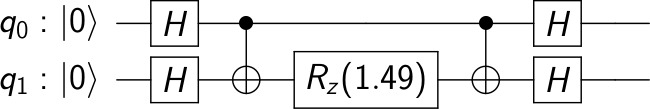

In [9]:
circuit.draw(output='latex')

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


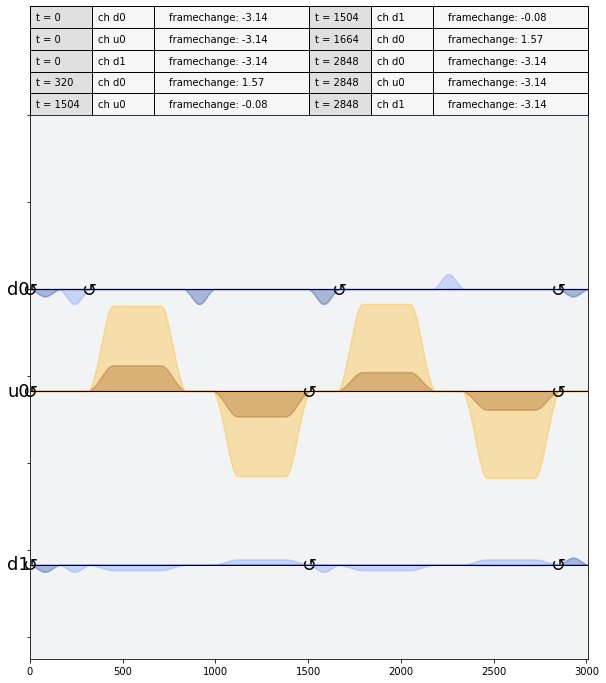

In [10]:
schedules[1].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [11]:
## Optimized Way Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.zz_interaction(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

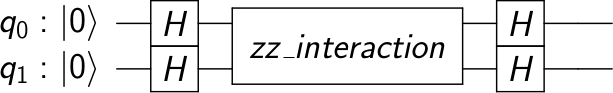

In [12]:
circuit.draw(output='latex')

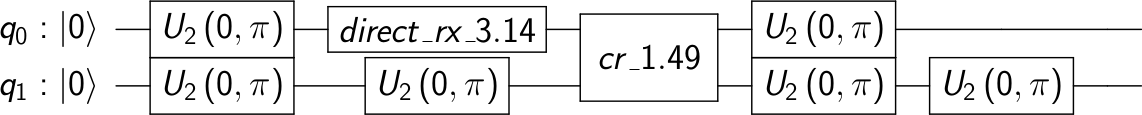

In [13]:
circuit.decompose().draw(output='latex')

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


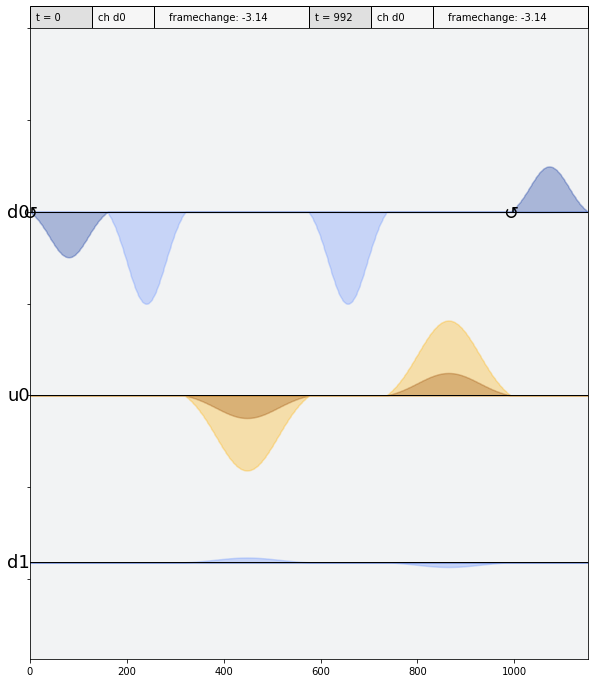

In [14]:
schedules[21].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [15]:
shots = 1000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dd76fabf5613200186ad136


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [35]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

# Run a mitigation cal job

In [17]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, euler_angles_1q
from qiskit.extensions.standard import U3Gate
from qiskit.circuit import Gate

def make_u3s(circ):
    new_circ = QuantumCircuit(*circ.qregs, *circ.cregs)
    for gate, qargs, cargs in circ.data:
        if len(qargs) == 1 and isinstance(gate, Gate):
            theta, phi, lam = euler_angles_1q(Operator(gate).data)
            new_circ.append(U3Gate(theta, phi, lam), qargs, cargs)
        else:
            new_circ.append(gate, qargs, cargs)
    return new_circ

In [10]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
#meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
#meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_qcs, backend, initial_layout=[0,1])

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [14]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [119]:
result = backend.retrieve_job('5dd76fabf5613200186ad136').result()

In [66]:
# mitigate results
result_mit = job_mit.result()
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.95996094, 0.06445312, 0.08496094, 0.01269531],
       [0.02246094, 0.921875  , 0.00390625, 0.08691406],
       [0.01660156, 0.00195312, 0.89160156, 0.06738281],
       [0.00097656, 0.01171875, 0.01953125, 0.83300781]])

In [92]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [120]:
standard_counts_list = []
for i in range(len(thetas)):
    counts = marginal_counts(result.get_counts(i), meas_qubits=[0,1])
    #counts = readout_fitter.filter.apply(counts)
    standard_counts_list.append(counts)
print(standard_counts_list)

[{'00': 943, '01': 36, '10': 17, '11': 4}, {'00': 940, '01': 36, '10': 19, '11': 5}, {'00': 945, '01': 39, '10': 7, '11': 9}, {'00': 944, '01': 30, '10': 15, '11': 11}, {'00': 929, '01': 26, '10': 16, '11': 29}, {'00': 902, '01': 38, '10': 17, '11': 43}, {'00': 875, '01': 44, '10': 17, '11': 64}, {'00': 871, '01': 44, '10': 21, '11': 64}, {'00': 855, '01': 38, '10': 29, '11': 78}, {'00': 819, '01': 55, '10': 29, '11': 97}, {'00': 816, '01': 43, '10': 25, '11': 116}, {'00': 785, '01': 49, '10': 27, '11': 139}, {'00': 769, '01': 52, '10': 20, '11': 159}, {'00': 723, '01': 50, '10': 32, '11': 195}, {'00': 672, '01': 53, '10': 33, '11': 242}, {'00': 633, '01': 53, '10': 43, '11': 271}, {'00': 631, '01': 61, '10': 44, '11': 264}, {'00': 611, '01': 57, '10': 43, '11': 289}, {'00': 549, '01': 64, '10': 42, '11': 345}, {'00': 512, '01': 51, '10': 50, '11': 387}]


In [121]:
optimized_counts_list = []
for i in range(len(thetas), len(thetas) * 2):
    counts = marginal_counts(result.get_counts(i), meas_qubits=[0,1])
    #counts = readout_fitter.filter.apply(counts)
    optimized_counts_list.append(counts)
print(optimized_counts_list)

[{'00': 956, '01': 31, '10': 9, '11': 4}, {'00': 964, '01': 20, '10': 11, '11': 5}, {'00': 924, '01': 41, '10': 16, '11': 19}, {'00': 921, '01': 31, '10': 17, '11': 31}, {'00': 903, '01': 38, '10': 8, '11': 51}, {'00': 894, '01': 30, '10': 20, '11': 56}, {'00': 860, '01': 44, '10': 24, '11': 72}, {'00': 825, '01': 44, '10': 35, '11': 96}, {'00': 817, '01': 43, '10': 32, '11': 108}, {'00': 821, '01': 38, '10': 28, '11': 113}, {'00': 791, '01': 47, '10': 30, '11': 132}, {'00': 727, '01': 53, '10': 37, '11': 183}, {'00': 730, '01': 38, '10': 42, '11': 190}, {'00': 700, '01': 47, '10': 29, '11': 224}, {'00': 655, '01': 50, '10': 43, '11': 252}, {'00': 593, '01': 40, '10': 45, '11': 322}, {'00': 601, '01': 47, '10': 39, '11': 313}, {'00': 586, '01': 48, '10': 44, '11': 322}, {'00': 529, '01': 74, '10': 54, '11': 343}, {'00': 501, '01': 54, '10': 48, '11': 397}]


In [131]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_state_vectors = []
for counts in standard_counts_list:
        standard_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

In [132]:
optimized_state_vectors = []
for counts in optimized_counts_list:
        optimized_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

### plot fidelities

In [124]:
from qiskit.quantum_info.states import Statevector
ideal_state_vectors = []
for c in circuits:
    ideal = Statevector.from_instruction(c).data
    ideal_state_vectors.append(ideal)

In [133]:
from qiskit.quantum_info import state_fidelity

standard_fidelities = []
for sv1, sv2 in zip(standard_state_vectors, ideal_state_vectors):
    fidelity = state_fidelity(sv1, sv2)
    standard_fidelities.append(fidelity)

optimized_fidelities = []
for sv1, sv2 in zip(optimized_state_vectors, ideal_state_vectors):
    fidelity = state_fidelity(sv1, sv2)
    optimized_fidelities.append(fidelity)

cross_fidelities = []
for sv1, sv2 in zip(standard_state_vectors, optimized_state_vectors):
    fidelity = state_fidelity(sv1, sv2)
    cross_fidelities.append(fidelity)

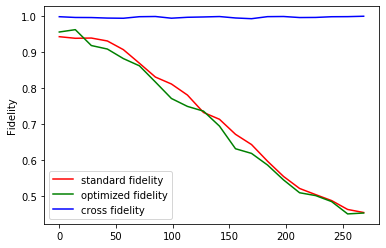

In [134]:
# raw
plt.plot(thetas * 180, standard_fidelities, 'r')
plt.plot(thetas * 180, optimized_fidelities, 'g')
plt.plot(thetas * 180, cross_fidelities, 'b')
plt.ylabel('Fidelity')
plt.legend(['standard fidelity', 'optimized fidelity', 'cross fidelity'])

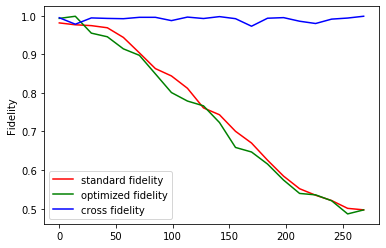

In [118]:
# mitigated
plt.plot(thetas * 180, standard_fidelities, 'r')
plt.plot(thetas * 180, optimized_fidelities, 'g')
plt.plot(thetas * 180, cross_fidelities, 'b')
plt.ylabel('Fidelity')
plt.legend(['standard fidelity', 'optimized fidelity', 'cross fidelity'])

### plot |11>

In [127]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_11s = []
for counts in standard_counts_list:
    standard_11s.append(counts.get('11', 0))
        
optimized_11s = []
for counts in optimized_counts_list:
    optimized_11s.append(counts.get('11', 0))
        
ideal_11s = []
for ideal in ideal_state_vectors:
    ideal_11s.append(1000 * np.abs(ideal[3]) ** 2)

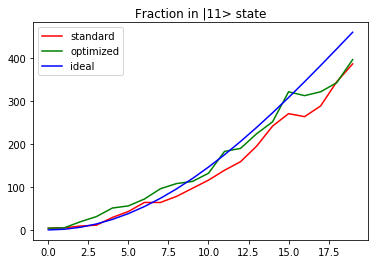

In [128]:
# raw
plt.plot(standard_11s, 'r', label='standard')
plt.plot(optimized_11s, 'g', label='optimized')
plt.plot(ideal_11s, 'b', label='ideal')
plt.title('Fraction in |11> state')
plt.legend()

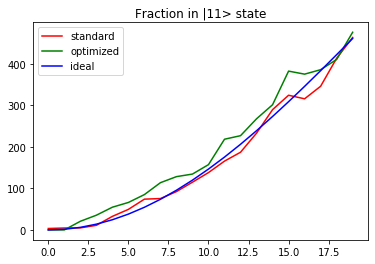

In [116]:
# mitigated
plt.plot(standard_11s, 'r', label='standard')
plt.plot(optimized_11s, 'g', label='optimized')
plt.plot(ideal_11s, 'b', label='ideal')
plt.title('Fraction in |11> state')
plt.legend()